#### Planetscope Analysis - Vegetation indices

##### This script:
- Reads multiple Planetscope reflectance images
- Calculates vegetation indices

Code is based on notebooks from Planetlabs, available here: https://github.com/planetlabs/notebooks  

Data used are from Planetscope 21.-26. June 2019 over a selected study area in the Brazilian Amazon.   
***

#### Vegetation Indices

| Index | Name                                    | Formula                                                                                         |
|-------|-----------------------------------------|-------------------------------------------------------------------------------------------------|
| NDVI  | Normalized Vegetation Index             | $\frac{NIR - R}{NIR + R}$                                                                       |
| IPVI  | Infrared Percentage Vegetation Index    | $\frac{NIR}{NIR + R}$                                                                           |
| RVI   | Simple Ratio/Ratio Vegetation Index     | $\frac{NIR}{R}$                                                                                 |
| SAVI  | Soil Adjusted Vegetation Index          | $\left(\frac{NIR - R}{NIR + R + L}\right) \times (1 + L)$ <br> $L$: in range [0,1], here 0.5        |
| MSAVI2| Modified Secondary Soil Adjusted Vegetation Index | $0.5 \times (2 \times NIR + 1 - \sqrt{(2 \times NIR + 1)^2 - 8 \times (NIR - R)})$  |
| ARVI  | Atmospheric Resistant Vegetation Index  | $\frac{NIR - RB}{NIR + RB}$                                                                     |
| DVI   | Difference Vegetation Index             | $NIR - R$                                                                                       |
| EVI   | Enhanced Vegetation Index               | $2.5 \times \left(\frac{NIR - R}{NIR + C1 \times R - C2 \times B + L}\right)$ <br> $C1: 6$ <br> $C2: 7.5$ <br> $L: 1$ |

In [38]:
# Install libraries
import numpy as np
import matplotlib
import rasterio
import fiona

#### Step 1. Set up project folders - rest is automatic
The following input and directory structure is required:

- *Number of images/scenes*


- *Project folder*  -  all folders inside Project folder


- *AnalyticMS folder*  -  only the AnalyticMS.tif files, no unusable datamasks(udm)


- *Metadata folder*  -  only the metadata.xml files


- *AOI folder*  -  just one AOI file in GeoJSON format


- *Results folder*  -  receives the exported images


In [39]:
n_images = 7
Project_folder = 'planet_21-26/'
Input_folder = 'planet_21-26/Input_folder/'
Metadata_folder = 'planet_21-26/Metadata_files/'
aoi_folder = 'planet_21-26/AOI/'
Results_folder = 'planet_21-26/Results_veg_ind/'

#### Step 2. Read and Inspect Images

In [40]:
# Use 6 scenes from 21.-26. June 2019 for coversion to TOA Reflectance
# Collect image filenames 
from os import walk
Input_files = []
for (dirpath, dirnames, filenames) in walk(Input_folder):
    Input_files.extend(filenames)
    break

# Add image file path
Input_path = []
for i in Input_files:
    Input_path.append(Input_folder + i)
    print(Input_folder + i) # Verify correct images

planet_21-26/Input_folder/20190721_133242_1034_3B_AnalyticMS_Ref_clip.tif
planet_21-26/Input_folder/20190721_Ref_Mosaic_Clip.tif
planet_21-26/Input_folder/20190722_133028_103a_3B_AnalyticMS_Ref_clip.tif
planet_21-26/Input_folder/20190723_131552_0f3d_3B_AnalyticMS_Ref_clip.tif
planet_21-26/Input_folder/20190724_131505_1_1050_3B_AnalyticMS_Ref_clip.tif
planet_21-26/Input_folder/20190725_133328_1042_3B_AnalyticMS_Ref_clip.tif
planet_21-26/Input_folder/20190726_133225_103a_3B_AnalyticMS_Ref_clip.tif


In [41]:
# Loading images into list using rasterio
img_list = []
for image in Input_path:
    img_list.append(rasterio.open(image))
print('Length of img_list: {} '.format(len(img_list)))

Length of img_list: 7 


In [42]:
# Inspecting image metadata
print("Image: dtype | crs | band count")
for image in img_list:
    print(image.meta['dtype'], image.meta['crs'], image.meta['count'])

Image: dtype | crs | band count
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4
uint16 EPSG:32722 4


#### Step 3. Extract the Data from Each Spectral Band
In this step, Rasterio (a Python library for reading and writing geospatial raster datasets) is used to open the raster images (the .tif files). 

Then, the band data will is extracted and loaded into arrays for further manipulation with Python's NumPy libary.

Note: in PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared.

In [43]:
# Radiance values are loaded into lists
band_blue = [0]*n_images
band_green = [0]*n_images
band_red = [0]*n_images
band_nir = [0]*n_images

# Reflectance images are scaled with factor of 10 000
# Multiply with 0.0001 to get values from 0.0-1.0
scale = 0.0001

# Convert to type 'float64'
from rasterio import float64
        
# Using rasterio to read radiance values for the images
for i in range(n_images):
    with rasterio.open(Input_path[i]) as src:
        band_blue[i] = (src.read(1) * scale).astype(float64)
    with rasterio.open(Input_path[i]) as src:
        band_green[i] = (src.read(2) * scale).astype(float64)
    with rasterio.open(Input_path[i]) as src:
        band_red[i] = (src.read(3) * scale).astype(float64)
    with rasterio.open(Input_path[i]) as src:
        band_nir[i] = (src.read(4) * scale).astype(float64)

Note that the coefficients are all of order 1e<sup>-5</sup>, and that the coefficient for NIR is significantly higher than the coefficient for blue. This is a big deal if your use case involves performing band math because a pixel with a NIR/blue ratio of 1.0 in the radiance image will have a NIR/blue ratio of 3.35/1.929=1.73 in the reflectance image.   
Most spectral indices are defined in terms of reflectance, not radiance.

#### Calculate Vegetation indices
Next we compute vegetation indices from the pixel values.

#### Vegetation Indices

| Index | Name                                    | Formula                                                                                         |
|-------|-----------------------------------------|-------------------------------------------------------------------------------------------------|
| NDVI  | Normalized Vegetation Index             | $\frac{NIR - R}{NIR + R}$                                                                       |
| IPVI  | Infrared Percentage Vegetation Index    | $\frac{NIR}{NIR + R}$                                                                           |
| RVI   | Simple Ratio/Ratio Vegetation Index     | $\frac{NIR}{R}$                                                                                 |
| SAVI  | Soil Adjusted Vegetation Index          | $\left(\frac{NIR - R}{NIR + R + L}\right) \times (1 + L)$ <br> $L$: in range [0,1], here 0.5        |
| MSAVI2| Modified Secondary Soil Adjusted Vegetation Index | $0.5 \times (2 \times NIR + 1 - \sqrt{(2 \times NIR + 1)^2 - 8 \times (NIR - R)})$  |
| ARVI  | Atmospheric Resistant Vegetation Index  | $\frac{NIR - RB}{NIR + RB}$                                                                     |
| DVI   | Difference Vegetation Index             | $NIR - R$                                                                                       |
| EVI   | Enhanced Vegetation Index               | $2.5 \times \left(\frac{NIR - R}{NIR + C1 \times R - C2 \times B + L}\right)$ <br> $C1: 6$ <br> $C2: 7.5$ <br> $L: 1$ |


In [44]:
ndvi_list = []; ipvi_list = []; rvi_list = []; savi_list = []
msavi2_list = []; arvi_list = []; dvi_list = []; evi_list = []

# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

for i in range(len(img_list)):
    
    B = band_blue[i]
    G = band_green[i]
    R = band_red[i]
    NIR = band_nir[i]

    # Calculate NDVI
    ndvi = (NIR - R) / (NIR + R)
    ndvi_list.append(ndvi)
    
    # Calculate EVI
    C1 = 6; C2 = 7.5; L = 1
    evi = 2.5 * ((NIR - R) / (NIR + C1 * R - C2 * B + L))
    evi_list.append(evi)
    
    # Calculate SAVI
    L = 0.5
    savi = ((NIR - R)/(NIR + R + L)) * 1.0 + L
    savi_list.append(savi)
    
    # Calculate MSAVI2
    msavi2 = 0.5 * (2 * NIR + 1 - np.sqrt(2 * NIR + 1) * 2 - 8*(NIR - R))
    msavi2_list.append(msavi2)
    
    # Calculate ARVI
    RB = (R - B)
    arvi = (NIR - RB)/(NIR + RB)
    arvi_list.append(arvi)
    
    # Calculate IPVI
    ipvi = NIR/(NIR + R)
    ipvi_list.append(ipvi)
    
    # Calculate DVI
    dvi = NIR - R
    dvi_list.append(dvi)
    
    # Calculate RVI
    rvi = NIR/R
    rvi_list.append(rvi)    

#### Visualizing results

In [45]:
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline

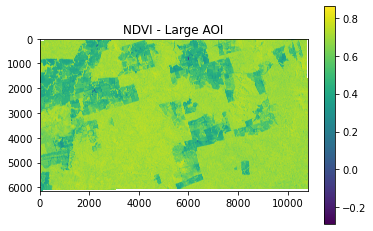

In [46]:
plt.imshow(ndvi_list[1], cmap='viridis')
# Add title and colorbar to show the index
plt.title("NDVI - Large AOI")
plt.colorbar()

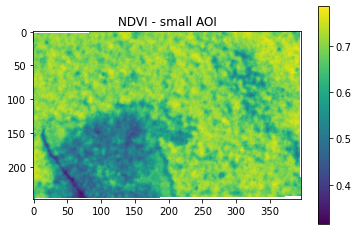

In [47]:
plt.imshow(ndvi_list[0], cmap='viridis')
# Add title and colorbar to show the index
plt.title("NDVI - small AOI")
plt.colorbar()

Text(0.5, 1.0, 'RVI')

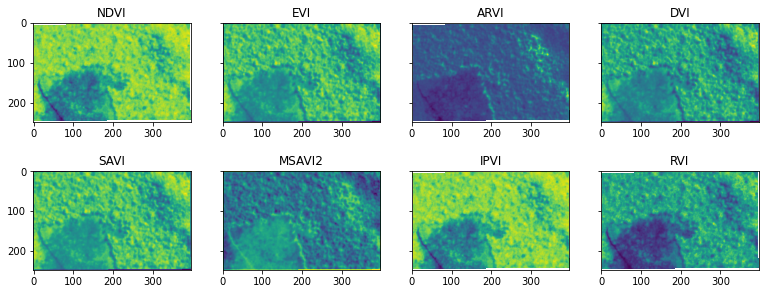

In [48]:
# Visualize vegetation indices
f, axarr = plt.subplots(2,4, figsize=(13,5), sharey=True)
axarr[0,0].imshow(ndvi_list[0]); axarr[0,2].imshow(arvi_list[0])
axarr[0,1].imshow(evi_list[0]); axarr[1,2].imshow(ipvi_list[0])
axarr[1,0].imshow(savi_list[0]); axarr[0,3].imshow(dvi_list[0])
axarr[1,1].imshow(msavi2_list[0]); axarr[1,3].imshow(rvi_list[0])

# Add titles
axarr[0,0].set_title("NDVI"); axarr[0,2].set_title("ARVI")
axarr[0,1].set_title("EVI"); axarr[1,2].set_title("IPVI")
axarr[1,0].set_title("SAVI"); axarr[0,3].set_title("DVI")
axarr[1,1].set_title("MSAVI2"); axarr[1,3].set_title("RVI")

#### Save the NDVI image
Finally we output these new pixel values to a new image file, making sure we mirror the GeoTIFF spatial metadata:

In [49]:
print(img_list[0].meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 397, 'height': 248, 'count': 4, 'crs': CRS.from_epsg(32722), 'transform': Affine(3.0, 0.0, 239181.0,
       0.0, -3.0, 9274158.0)}


In [50]:
from rasterio import float64

ndvi_scaled = [0]*n_images
evi_scaled = [0]*n_images
savi_scaled = [0]*n_images
msavi2_scaled = [0]*n_images
arvi_scaled = [0]*n_images
ipvi_scaled = [0]*n_images
dvi_scaled = [0]*n_images
rvi_scaled = [0]*n_images

for i in range(len(img_list)):
    
    # Set spatial characteristics of the output object to mirror the input
    kwargs = img_list[i].meta
    kwargs.update(
        dtype=rasterio.float64,
        count = 1)
    
    # As noted above, scale reflectance value by a factor of 10k:
    scale = 10000
    ndvi_scaled[i] = scale * ndvi_list[i]
    evi_scaled[i] = scale * evi_list[i]
    savi_scaled[i] = scale * savi_list[i]
    msavi2_scaled[i] = scale * msavi2_list[i]
    arvi_scaled[i] = scale * arvi_list[i]
    ipvi_scaled[i] = scale * ipvi_list[i]
    dvi_scaled[i] = scale * dvi_list[i]
    rvi_scaled[i] = scale * rvi_list[i]

    # Create the files
    with rasterio.open(Results_folder + Input_files[i].replace('.tif','_ndvi.tif'), 'w', **kwargs) as dst:
            dst.write_band(1, ndvi_list[i].astype(rasterio.float64))
            
    with rasterio.open(Results_folder + Input_files[i].replace('.tif','_evi.tif'), 'w', **kwargs) as dst:
            dst.write_band(1, evi_list[i].astype(rasterio.float64))
            
    with rasterio.open(Results_folder + Input_files[i].replace('.tif','_savi.tif'), 'w', **kwargs) as dst:
            dst.write_band(1, savi_list[i].astype(rasterio.float64))
            
    with rasterio.open(Results_folder + Input_files[i].replace('.tif','_msavi2.tif'), 'w', **kwargs) as dst:
            dst.write_band(1, msavi2_list[i].astype(rasterio.float64))
            
    with rasterio.open(Results_folder + Input_files[i].replace('.tif','_arvi.tif'), 'w', **kwargs) as dst:
            dst.write_band(1, arvi_list[i].astype(rasterio.float64))
            
    with rasterio.open(Results_folder + Input_files[i].replace('.tif','_ipvi.tif'), 'w', **kwargs) as dst:
            dst.write_band(1, ipvi_list[i].astype(rasterio.float64))
            
    with rasterio.open(Results_folder + Input_files[i].replace('.tif','_dvi.tif'), 'w', **kwargs) as dst:
            dst.write_band(1, dvi_list[i].astype(rasterio.float64))
            
    with rasterio.open(Results_folder + Input_files[i].replace('.tif','_rvi.tif'), 'w', **kwargs) as dst:
            dst.write_band(1, rvi_list[i].astype(rasterio.float64))

In [51]:
# checking reflectance values
ndvi_min = np.nanmin(ndvi_list[0]);    ndvi_max = np.nanmax(ndvi_list[0])
print("NDVI values goes from: {} to {}".format(ndvi_min, ndvi_max))

NDVI values goes from: 0.3156146179401993 to 0.7853226486714466
